# [Angle closure Glaucoma Evaluation Challenge](https://age.grand-challenge.org/Details/)
## Scleral spur localization Baseline （RCNN)

- To keep model training stable, images with coordinate == -1, were removed.
- For real inference, you MIGHT keep all images in val_file_path file.

## requirement install

In [1]:
!pip install xlrd
!pip install tqdm
!pip install pycocotools

Looking in indexes: http://pip.baidu.com/root/baidu/+simple/
Looking in indexes: http://pip.baidu.com/root/baidu/+simple/
Looking in indexes: http://pip.baidu.com/root/baidu/+simple/


## Zip File Extract

Assume `Training100.zip` and `Validation_ASOCT_Image.zip` are stored @ `./AGE_challenge Baseline/datasets/`

In [2]:
!unzip -q ../datasets/Training100.zip -d ../datasets/
!unzip -q ../datasets/Validation_ASOCT_Image.zip -d ../datasets/

unzip:  cannot find or open ../datasets/Training100.zip, ../datasets/Training100.zip.zip or ../datasets/Training100.zip.ZIP.
unzip:  cannot find or open ../datasets/Validation_ASOCT_Image.zip, ../datasets/Validation_ASOCT_Image.zip.zip or ../datasets/Validation_ASOCT_Image.zip.ZIP.


# Explore Data

In [3]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import cv2
import os, shutil
import pprint
import coco_parser
import json
import pandas as pd

%matplotlib inline

In [4]:
data_root_path = "../datasets/Training100/"
xlsx_file_path = os.path.join(data_root_path, "Training100_Location.xlsx")

image_path = os.path.join(data_root_path, "ASOCT_Image")
label_file_path = os.path.join(data_root_path, "train_loc.csv")

train_file_path = os.path.join(data_root_path, "train2017")
val_file_path = os.path.join(data_root_path, "val2017")

json_path = os.path.join(data_root_path, "annotations")
train_json_path = os.path.join(json_path, "instances_train2017.json")
val_json_path = os.path.join(json_path, "instances_val2017.json")

In [5]:
xlsx_file = pd.read_excel(xlsx_file_path)
xlsx_file.to_csv(label_file_path, 
                    index=False, columns=['ASOCT_Name', 'X1', 'Y1', 'X2', 'Y2'])

In [6]:
data_list = []

with open(label_file_path,'r') as f:  
    lines=csv.reader(f)  
    for key, line in enumerate(lines):  
        data_list.append(line)
        
pprint.pprint(data_list[:2])

[['ASOCT_Name', 'X1', 'Y1', 'X2', 'Y2'],
 ['T0056-10.jpg',
  '228.83365553922314',
  '466.95960107867666',
  '1870.8038638045307',
  '451.59230045548907']]


<Figure size 576x360 with 0 Axes>

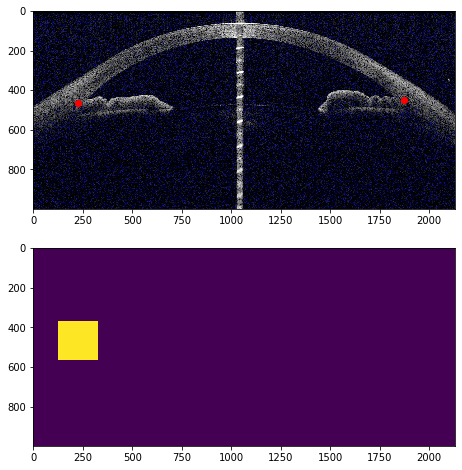

In [7]:
plt.figure(figsize=(8, 5))

file_name, l_x, l_y, r_x, r_y = data_list[1]
img = cv2.imread(os.path.join(image_path, file_name))[:,:,::-1]

binary_mask = np.zeros((img.shape[0], img.shape[1]))
l_x, l_y = int(float(l_x)), int(float(l_y))
binary_mask[l_y - 100 : l_y + 100, l_x - 100 : l_x + 100] = 1

plt.figure(figsize=(8,8))

plt.subplot(2,1,1)
plt.imshow(img)
plt.scatter(float(l_x), float(l_y), c='r')
plt.scatter(float(r_x), float(r_y), c='r')

plt.subplot(2,1,2)
plt.imshow(binary_mask)

# Train/Val split

In [8]:
def train_val_split(data_list, train_ratio=0.8, shuffle_seed=42):
    testee_list = list(set( [line[0].split("-")[0] for line in data_list[1:]] ))
    
    val_testee_idx = np.random.choice(testee_list, int(len(testee_list) * (1-train_ratio)), replace=False)

    train_list = []
    val_list = []
    
    for line in data_list[1:]:
        file_name = line[0]
        if file_name.split("-")[0] in val_testee_idx:
            val_list.append(line)
        else:
            train_list.append(line)
            
    return train_list, val_list

In [9]:
train_data_list, val_data_list = train_val_split(data_list)
print(len(train_data_list))
print(len(val_data_list))

1296
304


In [10]:
def center_split(img, l_point, r_point):
    # img: 3D nparray
    # l_point/r_point: (x,y)
    nrow, ncol, ch = img.shape
    left_img, right_img = img[:,:nrow,:], img[:,-nrow:,:]
    
#     l_point = l_point
    r_point = (r_point[0] - (ncol-nrow), r_point[1])
    return left_img, right_img, l_point, r_point

In [11]:
split_train_list = []

if os.path.exists(train_file_path):
    shutil.rmtree(train_file_path)
os.mkdir(train_file_path)

for item in train_data_list:
    file_name, l_x, l_y, r_x, r_y = item
    img = cv2.imread(os.path.join(image_path, file_name))
    # split
    left_img, right_img, l_point, r_point = center_split(img, (float(l_x), float(l_y)), (float(r_x), float(r_y)))
    cv2.imwrite(os.path.join( train_file_path, file_name.split(".")[0]+'_left.jpg'), left_img)
    cv2.imwrite(os.path.join( train_file_path, file_name.split(".")[0]+'_right.jpg'), right_img)

    split_train_list.append([file_name.split(".")[0]+'_left.jpg', *l_point])
    split_train_list.append([file_name.split(".")[0]+'_right.jpg', *r_point])

<Figure size 1080x360 with 0 Axes>

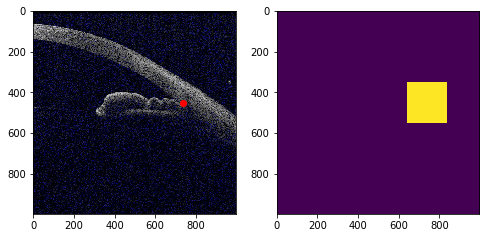

In [12]:
plt.figure(figsize=(15,5))

file_name, l_x, l_y = split_train_list[1]
img = cv2.imread(os.path.join(train_file_path, file_name))[:,:,::-1]

binary_mask = np.zeros((img.shape[0], img.shape[1]))
l_x, l_y = int(float(l_x)), int(float(l_y))
binary_mask[l_y - 100 : l_y + 100, l_x - 100 : l_x + 100] = 1

plt.figure(figsize=(8,8))

plt.subplot(1,2,1)
plt.imshow(img)
plt.scatter(float(l_x), float(l_y), c='r')

plt.subplot(1,2,2)
plt.imshow(binary_mask)

In [13]:
split_val_list = []

if os.path.exists(val_file_path):
    shutil.rmtree(val_file_path)
os.mkdir(val_file_path)

for item in val_data_list:
    file_name, l_x, l_y, r_x, r_y = item
    img = cv2.imread(os.path.join(image_path, file_name))
    # split
    left_img, right_img, l_point, r_point = center_split(img, (float(l_x), float(l_y)), (float(r_x), float(r_y)))
    cv2.imwrite(os.path.join( val_file_path, file_name.split(".")[0]+'_left.jpg'), left_img)
    cv2.imwrite(os.path.join( val_file_path, file_name.split(".")[0]+'_right.jpg'), right_img)

    split_val_list.append([file_name.split(".")[0]+'_left.jpg', *l_point])
    split_val_list.append([file_name.split(".")[0]+'_right.jpg', *r_point])

In [14]:
# Remove -1 in get_coco_dict()
coco_train_dict = coco_parser.get_coco_dict(train_file_path, split_train_list, box_range=100)
coco_val_dict = coco_parser.get_coco_dict(val_file_path, split_val_list, box_range=100)

In [15]:
if not os.path.exists(json_path):
    os.mkdir(json_path)

with open(train_json_path, 'w+') as output_json_file:
    json.dump(coco_train_dict, output_json_file)

with open(val_json_path, 'w+') as output_json_file:
    json.dump(coco_val_dict, output_json_file)